In [ ]:
!wget !wget https://github.com/HuynhBaThuan/DATN/raw/main/AI/src/data/FER.zip -O data.zip
!unzip data.zip -d data

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: data/train/sad/Training_65242339.jpg  
  inflating: data/train/sad/Training_65267116.jpg  
  inflating: data/train/sad/Training_65275626.jpg  
  inflating: data/train/sad/Training_6529266.jpg  
  inflating: data/train/sad/Training_65329617.jpg  
  inflating: data/train/sad/Training_65338712.jpg  
  inflating: data/train/sad/Training_65338797.jpg  
  inflating: data/train/sad/Training_65387162.jpg  
  inflating: data/train/sad/Training_65404494.jpg  
  inflating: data/train/sad/Training_65426218.jpg  
  inflating: data/train/sad/Training_65430136.jpg  
  inflating: data/train/sad/Training_65437377.jpg  
  inflating: data/train/sad/Training_6545735.jpg  
  inflating: data/train/sad/Training_65463385.jpg  
  inflating: data/train/sad/Training_65473985.jpg  
  inflating: data/train/sad/Training_65502829.jpg  
  inflating: data/train/sad/Training_65505359.jpg  
  inflating: data/train/sad/Training_65508578.jpg  
  inflati

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
from keras.utils import plot_model

In [2]:
from IPython.display import SVG, Image

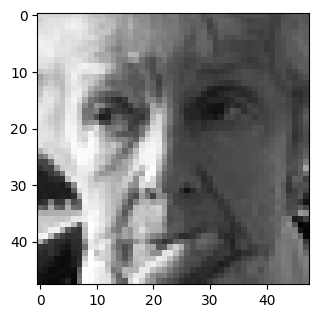

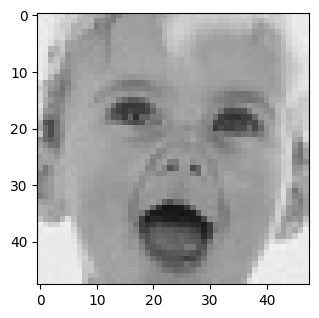

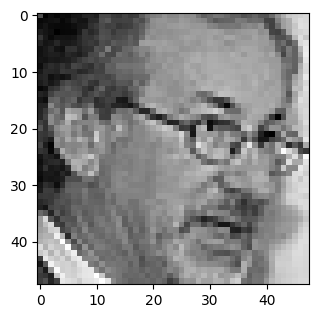

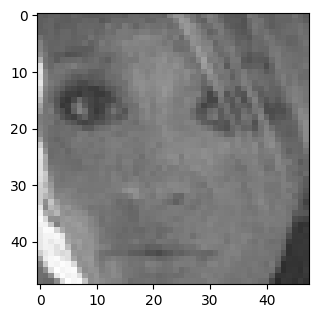

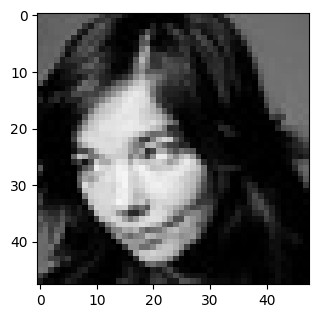

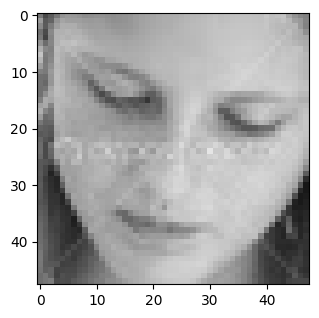

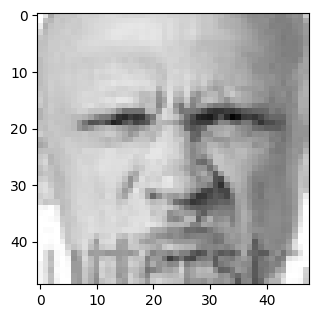

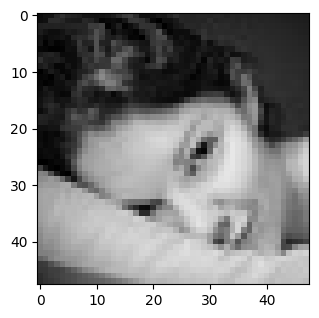

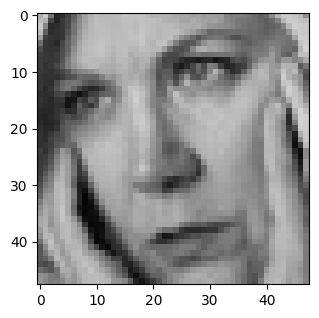

In [ ]:
train_img=("../data/train/**/**")
images=glob(train_img)
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))#;plt.axis('off')

In [3]:
train_dir = '../data/train'
test_dir = "../data/test_new"
val_dir = "../data/val_new"

row = 48
col = 48
classes = len(os.listdir('../data/train'))

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                   width_shift_range= 0.1,
                                   height_shift_range= 0.1,
                                   shear_range= 0.2 )



training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory(val_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=False,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.


In [13]:
# Function to count images in each class
def count_images_in_directory(directory):
    class_counts = {}
    # Iterate over class directories and count images
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

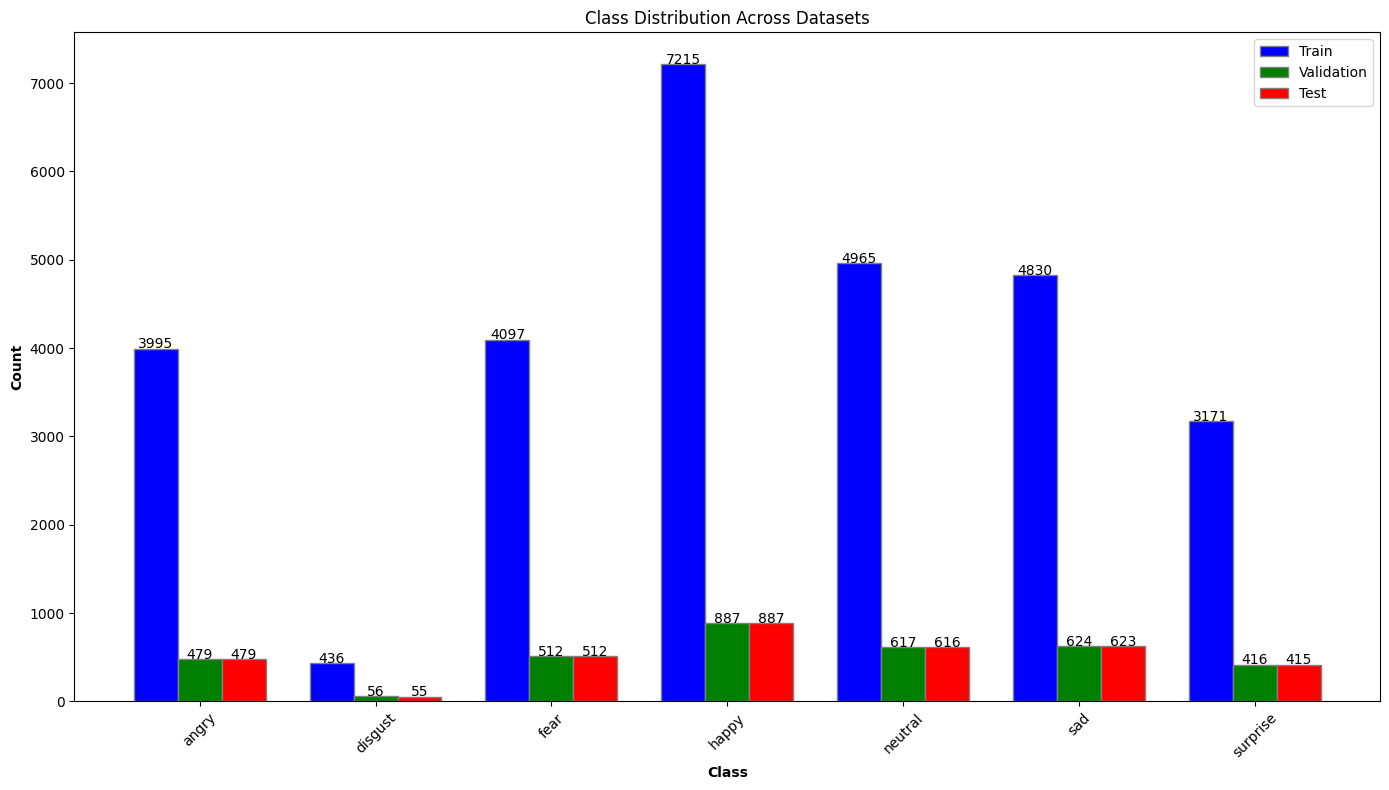

In [14]:
import seaborn as sns
# Get class counts for training, validation, and test datasets
train_class_counts = count_images_in_directory(train_dir)

# Get test set class counts
val_class_counts = count_images_in_directory(val_dir)

# Get validation set class counts
test_class_counts = count_images_in_directory(test_dir)

def plot_combined_class_distribution(train_data, val_data, test_data):
    classes = sorted(set(train_data.keys()).union(set(val_data.keys()), set(test_data.keys())))
    train_counts = [train_data.get(cls, 0) for cls in classes]
    val_counts = [val_data.get(cls, 0) for cls in classes]
    test_counts = [test_data.get(cls, 0) for cls in classes]
    
    bar_width = 0.25
    r1 = range(len(classes))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.figure(figsize=(14, 8))
    
    bars1 = plt.bar(r1, train_counts, color='b', width=bar_width, edgecolor='grey', label='Train')
    bars2 = plt.bar(r2, val_counts, color='g', width=bar_width, edgecolor='grey', label='Validation')
    bars3 = plt.bar(r3, test_counts, color='r', width=bar_width, edgecolor='grey', label='Test')
    
    plt.xlabel('Class', fontweight='bold')
    plt.ylabel('Count', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(classes))], classes, rotation=45)
    plt.title('Class Distribution Across Datasets')
    
    plt.legend()
    
    # Adding the count labels on top of the bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height + 3, '%d' % int(height), ha='center', size=10)
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    plt.tight_layout()
    plt.show()

plot_combined_class_distribution(train_class_counts, val_class_counts, test_class_counts)

In [15]:
def get_model(input_size, classes=7):
     #Initialising the CNN
     model = tf.keras.models.Sequential()

     model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
     model.add(BatchNormalization())
     model.add(MaxPooling2D(2, 2))
     model.add(Dropout(0.25))

     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
     model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(BatchNormalization())
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))

     model.add(Flatten())
     model.add(Dense(1024, activation='relu'))
     model.add(Dropout(0.5))

     model.add(Dense(classes, activation='softmax'))

     #Compliling the model
     model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
     return model

In [16]:
fernet = get_model((48,48,1))
fernet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,116,743 (122.52 MB)

 Trainable params: 32,116,103 (122.51 MB)

 Non-trainable params: 640 (2.50 KB)

In [18]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
chk_path = 'ferNet.keras'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=150,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/150
448/448 [==============================] - ETA: 0s - loss: 4.3699 - accuracy: 0.2518
Epoch 1: val_accuracy improved from inf to 0.22168, saving model to ferNet.keras
448/448 [==============================] - 61s 116ms/step - loss: 4.3699 - accuracy: 0.2518 - val_loss: 5.4121 - val_accuracy: 0.2217 - lr: 1.0000e-04
Epoch 2/150
448/448 [==============================] - ETA: 0s - loss: 3.6291 - accuracy: 0.2969
Epoch 2: val_accuracy did not improve from 0.22168
448/448 [==============================] - 30s 68ms/step - loss: 3.6291 - accuracy: 0.2969 - val_loss: 3.2093 - val_accuracy: 0.3816 - lr: 1.0000e-04
Epoch 3/150
448/448 [==============================] - ETA: 0s - loss: 3.0855 - accuracy: 0.3301
Epoch 3: val_accuracy did not improve from 0.22168
448/448 [==============================] - 30s 67ms/step - loss: 3.0855 - accuracy: 0.3301 - val_loss: 2.7333 - val_accuracy: 0.3941 - lr: 1.0000e-04
Epoch 4/150
448/448 [==============================] - ETA: 0s - loss: 2.65

In [ ]:
total_accuracy = 0
num_iterations = 5

for _ in range(num_iterations):
    accuracy = fernet.evaluate(test_set)
    total_accuracy += accuracy

average_accuracy = total_accuracy / num_iterations
print("Average Accuracy:", average_accuracy)

In [ ]:
fernet.evaluate(test_set)

113/113 [==============================] - 3s 27ms/step - loss: 0.9821 - accuracy: 0.6838


[0.9820840358734131, 0.6837559342384338]

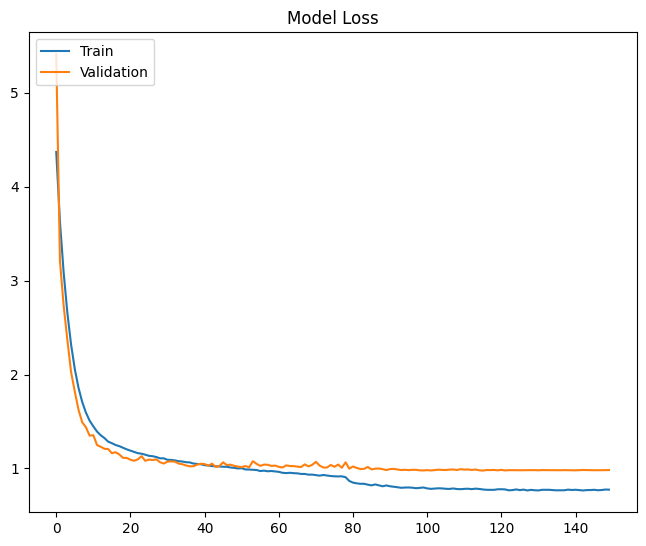

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

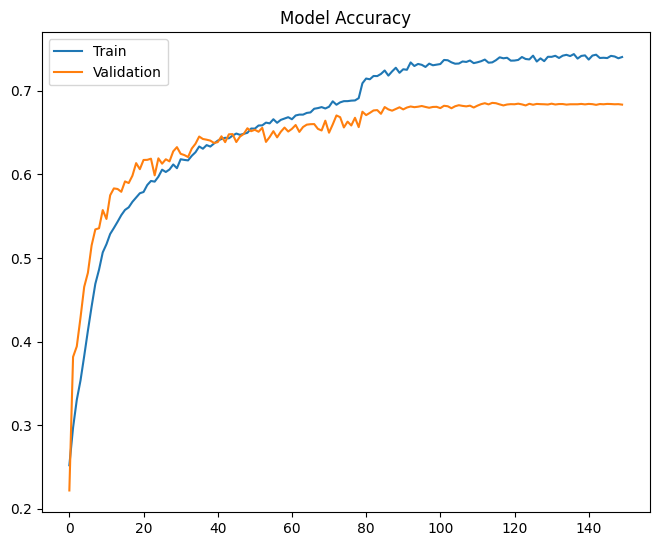

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [ ]:
print("Training Loss:", hist.history['loss'])
print("Validation Loss:", hist.history['val_loss'])

Training Loss: [4.36991548538208, 3.629145383834839, 3.0854644775390625, 2.65743088722229, 2.3198859691619873, 2.0591626167297363, 1.8592473268508911, 1.7081239223480225, 1.5952006578445435, 1.5088918209075928, 1.448006272315979, 1.3924486637115479, 1.3527952432632446, 1.3235751390457153, 1.285253643989563, 1.2688976526260376, 1.24973464012146, 1.2373936176300049, 1.2199465036392212, 1.2033002376556396, 1.189658284187317, 1.1758406162261963, 1.1626615524291992, 1.15688157081604, 1.1462668180465698, 1.1343419551849365, 1.1304470300674438, 1.121113896369934, 1.107711911201477, 1.1076956987380981, 1.0916460752487183, 1.0908077955245972, 1.085721731185913, 1.077134132385254, 1.0735362768173218, 1.0662624835968018, 1.0642004013061523, 1.0517791509628296, 1.0485414266586304, 1.0447524785995483, 1.0346165895462036, 1.0316646099090576, 1.025354027748108, 1.0224133729934692, 1.0210785865783691, 1.017978310585022, 1.0171637535095215, 1.0100454092025757, 1.0059553384780884, 0.9997876882553101, 1.

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 21ms/step - loss: 0.9821 - accuracy: 0.6838
final train accuracy = 79.59 , validation accuracy = 68.38


In [ ]:
model_json=fernet.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)

In [ ]:
from google.colab import files

In [ ]:
files.download('model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('ferNet.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('training.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('fernet.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fernet.save('model_17_5_file.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
files.download('model_17_5_file.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Lưu lịch sử huấn luyện vào một tệp
with open('training_history_17_5.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

In [ ]:
files.download('training_history_17_5.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('training_history_17_5.pkl')

In [5]:
from keras.models import load_model
fernet = load_model('../model/model_17_5_file.h5')

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
fernet.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [7]:
test_loss, test_accuracy = fernet.evaluate(test_set)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 726ms/step - accuracy: 0.6526 - loss: 1.0781
Test loss: 0.9667479991912842, Test accuracy: 0.6930582523345947


In [8]:
import time
import numpy as np

# Đo thời gian dự đoán cho một lô dữ liệu
def measure_inference_speed(model, data):
    start_time = time.time()
    predictions = model.predict(data)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, predictions

# Đánh giá tốc độ dự đoán
test_data = np.random.rand(1000, 48, 48, 1)  # Example test data, adjust according to your model input shape
inference_time, predictions = measure_inference_speed(fernet, test_data)
print(f"Inference time for 1000 samples: {inference_time} seconds")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
Inference time for 1000 samples: 4.136148452758789 seconds


In [9]:
from sklearn.metrics import confusion_matrix

# Dự đoán nhãn cho tập kiểm tra
predictions = fernet.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_set.classes  # Nhãn thực tế từ generator

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tính độ chính xác của từng lớp
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Vẽ biểu đồ
emotions = list(test_set.class_indices.keys())  # Lấy tên của các lớp từ generator

57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step


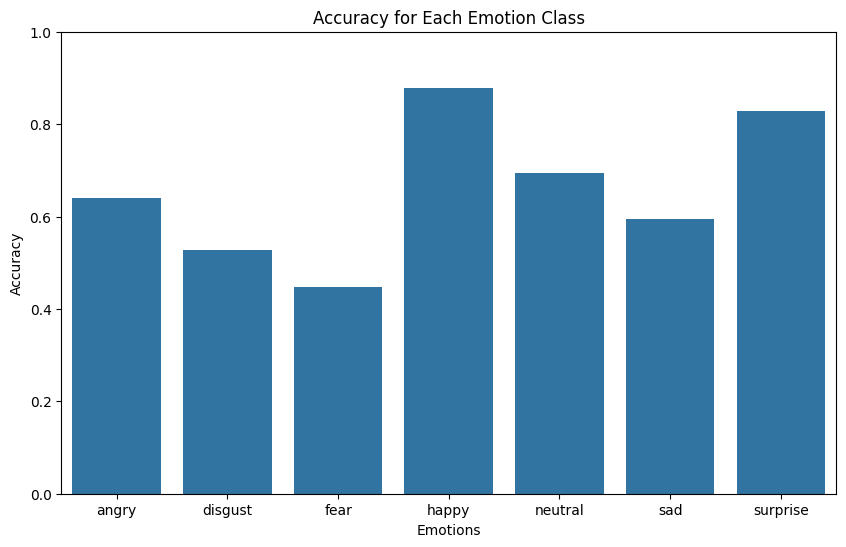

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions, y=class_accuracy)
plt.xlabel('Emotions')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Emotion Class')
plt.ylim(0, 1)
plt.show()

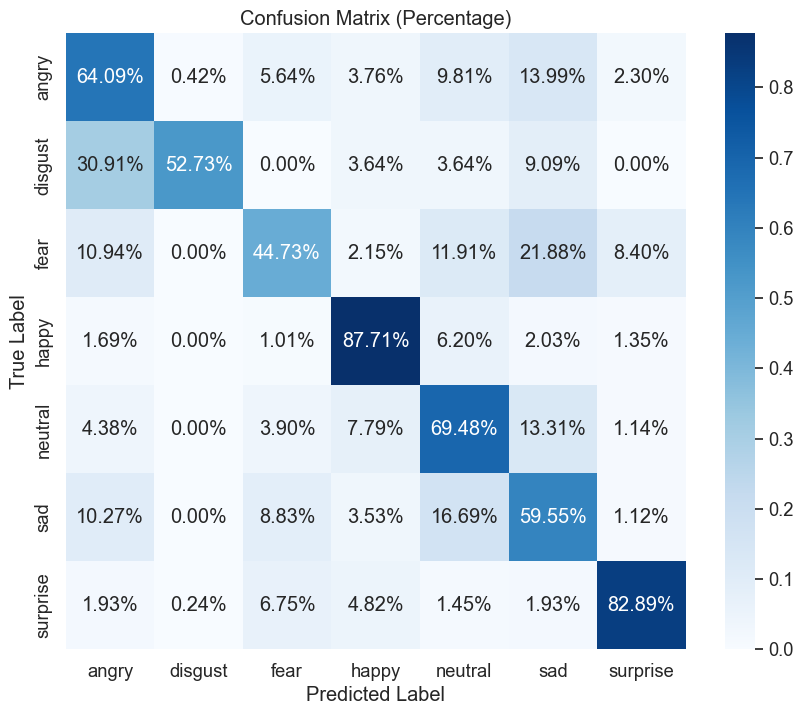

In [15]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Vẽ ma trận nhầm lẫn với các giá trị phần trăm
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Cài đặt kích thước font
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

test_predictions = fernet.predict(test_set)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

# Tạo báo cáo phân loại
report = classification_report(true_classes, test_predictions_classes, target_names=class_labels, output_dict=True)

# Chuyển báo cáo phân loại thành DataFrame
report_df = pd.DataFrame(report).transpose()

# Tính toán các chỉ số
accuracy = accuracy_score(true_classes, test_predictions_classes)
macro_avg = precision_recall_fscore_support(true_classes, test_predictions_classes, average='macro')
weighted_avg = precision_recall_fscore_support(true_classes, test_predictions_classes, average='weighted')


# In ra kết quả
print("Accuracy: {:.2f}".format(accuracy))
print("Macro Avg - Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(macro_avg[0], macro_avg[1], macro_avg[2]))
print("Weighted Avg - Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(weighted_avg[0], weighted_avg[1], weighted_avg[2]))

# In ra báo cáo phân loại dưới dạng bảng
print("\n{:<15} {:<10} {:<10} {:<10} {:<10}".format('Class', 'Precision', 'Recall', 'F1-score', 'Support'))
print("="*55)
for cls, metrics in report.items():
    if cls not in ['accuracy', 'macro avg', 'weighted avg']:
        print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10}".format(cls, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']))

# Thêm dòng cho 'accuracy'
print("="*55)
print("{:<15} {:<10} {:<10} {:<10.2f} {:<10}".format('accuracy', '', '', accuracy, report['macro avg']['support']))

# Thêm dòng cho 'macro avg'
print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10}".format('macro avg', macro_avg[0], macro_avg[1], macro_avg[2], report['macro avg']['support']))

# Thêm dòng cho 'weighted avg'
print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10}".format('weighted avg', weighted_avg[0], weighted_avg[1], weighted_avg[2], report['macro avg']['support']))


57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step
Accuracy: 0.69
Macro Avg - Precision: 0.71, Recall: 0.66, F1-score: 0.68
Weighted Avg - Precision: 0.69, Recall: 0.69, F1-score: 0.69

Class           Precision  Recall     F1-score   Support   
angry           0.62       0.64       0.63       479.0     
disgust         0.91       0.53       0.67       55.0      
fear            0.62       0.45       0.52       512.0     
happy           0.87       0.88       0.87       887.0     
neutral         0.61       0.69       0.65       616.0     
sad             0.56       0.60       0.58       623.0     
surprise        0.81       0.83       0.82       415.0     
accuracy                              0.69       3587.0    
macro avg       0.71       0.66       0.68       3587.0    
weighted avg    0.69       0.69       0.69       3587.0    
